In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu117

In [2]:
# Global Libraries
import collections
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os
from sklearn import metrics

# MXNet ND-Arrays with Numpy notation
mx.npx.set_np()

# Local Libraries
import model
import utils

# GPU mode
ctx = mx.gpu()

In [3]:
# python3 -m pip install pandas
# python3 -m pip install seaborn
# python3 -m pip install scikit-learn

import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
if not os.path.exists("cats_dogs_light.zip"):
    !wget https://zenodo.org/record/5226945/files/cats_dogs_light.zip?download=1 -O cats_dogs_light.zip

In [5]:
# Load Dataset: Dogs vs Cats Light Version
# Full dataset available: https://www.kaggle.com/c/dogs-vs-cats
# Light version available: https://zenodo.org/record/5226945#.Y9ZYCezP3VZ
from importlib import reload
reload(utils)

path = os.getcwd()

# Variables for dataset loading & pre-processing for plotting
imageNet = False
batch_size = 32

# Pre-processing the data, splitting training, validation and test set

# For Full Dataset (25k samples)
# Training set 20k samples (80%), Val set 2500 samples (10%), Test set 2500 samples (10%)
# light=False
# split = [0.8, 0.1, 0.1]

# For light version Dataset (1000 samples for Train+Val, 400 samples for Test)
# Training set 800 samples (80%), Val set 200 samples (20%), Test set 400 samples
light=True
split = [0.8, 0.2]

if not os.path.exists("./cats_dogs_light"):
    utils.preprocess_kaggle_cats_vs_dogs(path, split, light=light)

# Generate DataLoader without pre-processing for ImageNet for visualization purposes (light dataset version)
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=batch_size)

classes = ["Cats", "Dogs"]

number_of_features = 224 * 224

/home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/utils.py:273: UserWarning: Ignoring /home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/cats_dogs_light/train/cat.0.jpg, which is not a directory.
  train_dataset = ImageFolderDataset(train_path)
/home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/utils.py:273: UserWarning: Ignoring /home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/cats_dogs_light/train/cat.1.jpg, which is not a directory.
  train_dataset = ImageFolderDataset(train_path)
/home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/utils.py:273: UserWarning: Ignoring /home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/cats_dogs_light/train/cat.10.jpg, which is not a directory.
  train_dataset = ImageFolderDataset(train_path)
/home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/utils.py:273: UserWarning: Ignoring /home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/cats_dogs_l

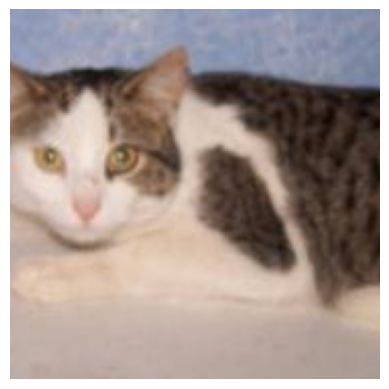

In [6]:
# Example image/label pair for qualitative evaluation
example_idx = 1
example_img = test_dataset[example_idx][0].asnumpy()
example_label = test_dataset[example_idx][1]
plt.axis('off')
plt.imshow(example_img)

In [7]:
print(val_dataset[0][0].shape)

(224, 224, 3)


Number of batches seen: 1


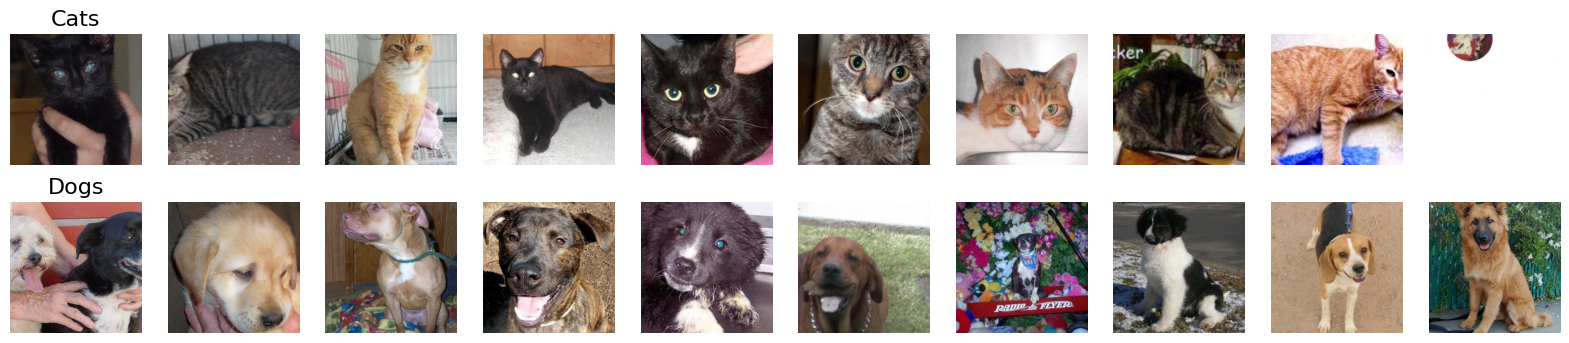

In [8]:
# Images in Grid Format

number_of_classes = len(classes)
number_of_images_per_class = 10

#fig, axes = plt.subplots(number_of_classes, number_of_images_per_class)#, figsize=(2, 20))
fig = plt.figure(figsize=(20, 4))

# Keep track of instances found
instances_per_class = {}
remaining_instances_to_be_found = set(range(number_of_classes))

# Traverse through the training set to find the 1st instances per class (number_of_images_per_class)
for iteration, (X_batch, y_batch) in enumerate(train_dataldr):    
    for X, y in zip(X_batch, y_batch):
        
        # Format inputs
        X = X.asnumpy()
        y = y.asnumpy().item()

        if y in instances_per_class and instances_per_class[y] == 10:
            if y in remaining_instances_to_be_found:
                remaining_instances_to_be_found.remove(y)
            continue
        
        if y not in instances_per_class:
            instances_per_class[y] = 0
            axes = fig.add_subplot(2, 10, y * 10 + 1)
            axes.set_title(classes[y], fontsize=16)
        else:
            axes = fig.add_subplot(2, 10, y * 10 + instances_per_class[y] + 1)

        axes.imshow(X)
        axes.axis('off')

        instances_per_class[y] += 1

    if not remaining_instances_to_be_found:
        # We are done
        break

print("Number of batches seen:", iteration + 1)

## Generate Datasets and DataLoaders (data iterators)

In [9]:
# Generate DataLoader with pre-processing for ImageNet (light dataset version)
imageNet=True
light=True
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
_, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(None, None, test_dataset, batch_size=32)

# For Qualitative Evaluation
example_image_preprocessed = np.expand_dims(test_dataset[example_idx][0].as_in_context(ctx), axis=0)

[21:03:54] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


## Training from scratch

In [10]:
# Back to NumPy Semantics
mx.npx.set_np()

# ResNet50 from Model Zoo (This downloads v1d)
# No Pre-trained weights (training from scratch)
resnet50 = gcv.model_zoo.get_model("resnet50_v1d", pretrained=False, ctx=ctx, classes=2)

In [11]:
import model
reload(model)

# Define Loss Function (Binary, cats vs dogs)
# loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 100
batch_size = 16
resnet50.initialize(mx.init.MSRAPrelu(), ctx=ctx)

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(resnet50.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50.collect_params(), "sgd", {"learning_rate": 0.001})

training_loss, training_acc, validation_loss, validation_acc = model.training_loop(resnet50,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

[21:03:56] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


E:    1, TrL: 1.362728, TrAcc: 0.568750, VL: 0.835853, VAcc: 0.550000 --- Updating saved model
E:    2, TrL: 0.767126, TrAcc: 0.590000, VL: 0.716608, VAcc: 0.505000
E:    3, TrL: 0.751814, TrAcc: 0.573750, VL: 0.729608, VAcc: 0.580000 --- Updating saved model
E:    4, TrL: 0.761904, TrAcc: 0.572500, VL: 0.875033, VAcc: 0.545000
E:    5, TrL: 0.655278, TrAcc: 0.617500, VL: 0.758757, VAcc: 0.610000 --- Updating saved model
E:    6, TrL: 0.642454, TrAcc: 0.618750, VL: 0.884319, VAcc: 0.500000
E:    7, TrL: 0.671126, TrAcc: 0.612500, VL: 0.719382, VAcc: 0.565000
E:    8, TrL: 0.627869, TrAcc: 0.646250, VL: 1.061936, VAcc: 0.570000
E:    9, TrL: 0.633894, TrAcc: 0.663750, VL: 0.863110, VAcc: 0.550000
E:   10, TrL: 0.611892, TrAcc: 0.671250, VL: 1.855833, VAcc: 0.585000
E:   11, TrL: 0.651513, TrAcc: 0.636250, VL: 0.804190, VAcc: 0.585000
E:   12, TrL: 0.702370, TrAcc: 0.657500, VL: 0.802521, VAcc: 0.635000 --- Updating saved model
E:   13, TrL: 0.687218, TrAcc: 0.632500, VL: 0.842590, VAcc:

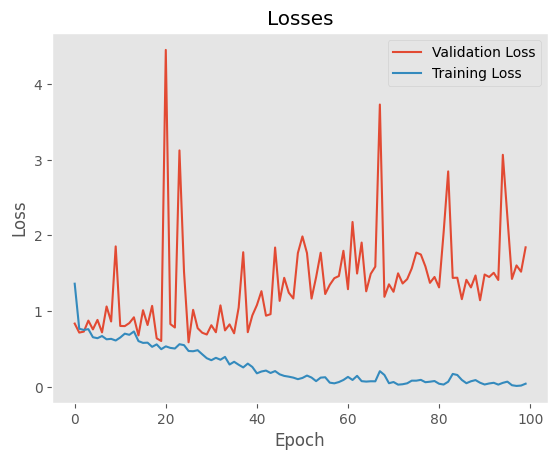

In [12]:
# plot the losses
epochs = 100
fig = plt.figure
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [13]:
# Load best model trained
resnet50.load_parameters(model.MODEL_FILE_NAME, ctx=ctx)

# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50(images.as_in_context(ctx))
    
    softmax_output = mx.nd.softmax(output.as_nd_ndarray())
    class_output = np.argmax(softmax_output, axis=1)    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

[21:11:01] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


('accuracy', 0.7175)


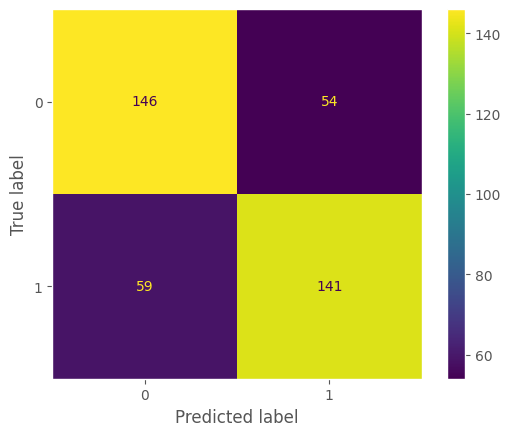

In [14]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp = cm_disp.plot(ax=None)
plt.grid(False)
plt.show()

In [15]:
# Qualitative Evaluation
# Expected Output 
print("Expected Output:", example_label) 
 
# Model Output
example_output = resnet50(example_image_preprocessed)
class_output = np.argmax(example_output, axis=1).asnumpy()[0] 
print("Class Output:", class_output) 
assert class_output == 0 # Cat 

Expected Output: 0
Class Output: 0


## Pre-Trained Model

In [16]:
# Back to NumPy Semantics
mx.npx.set_np()

# ResNet50 from Model Zoo (This downloads v1d)
# No Pre-trained weights (training from scratch)
resnet50 = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

In [17]:
# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50(images.as_in_context(ctx))
    
    class_output_imagenet = np.argmax(output, axis=1)
    class_output = mx.nd.array([model.CLASSES_DICT[idx] for idx in class_output_imagenet.asnumpy()])
    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

('accuracy', 0.925)


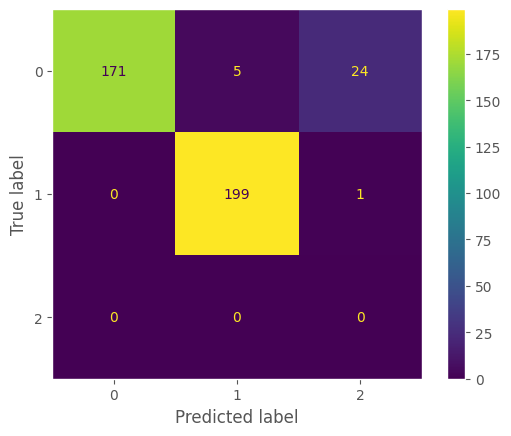

In [18]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp = cm_disp.plot(ax=None)
plt.grid(False)
plt.show()

In [19]:
# Qualitative Evaluation
# Expected Output 
print("Expected Output:", example_label) 
 
# Model Output
example_output = resnet50(example_image_preprocessed)
class_output = model.CLASSES_DICT[np.argmax(example_output, axis=1).asnumpy()[0]]
print("Class Output:", class_output) 
assert class_output == 0 # Cat 

Expected Output: 0
Class Output: 0


## Transfer-Learning

In [21]:
import model
reload(model)

# Build on top of Pre-Trained model
resnet50_tl = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

# Freeze Layers (keeping track of the updated parameters)
updated_params = []
for param in resnet50_tl.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"
        updated_params += [param.name]

# Replace the classifier (with gradients activated)
resnet50_tl.fc = mx.gluon.nn.Dense(2)
resnet50_tl.fc.initialize(ctx=ctx)

# Define Loss Function (Binary, cats vs dogs)
# loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 10
batch_size = 16

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(resnet50_tl.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50_tl.collect_params(), "sgd", {"learning_rate": 0.001})

training_loss, training_acc, validation_loss, validation_acc = model.training_loop(resnet50_tl,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

E:    1, TrL: 0.320263, TrAcc: 0.862500, VL: 0.143090, VAcc: 0.950000 --- Updating saved model
E:    2, TrL: 0.126650, TrAcc: 0.956250, VL: 0.106398, VAcc: 0.955000 --- Updating saved model
E:    3, TrL: 0.069736, TrAcc: 0.982500, VL: 0.079106, VAcc: 0.980000 --- Updating saved model
E:    4, TrL: 0.064852, TrAcc: 0.977500, VL: 0.064090, VAcc: 0.980000
E:    5, TrL: 0.051011, TrAcc: 0.980000, VL: 0.061625, VAcc: 0.975000
E:    6, TrL: 0.043181, TrAcc: 0.992500, VL: 0.065321, VAcc: 0.975000
E:    7, TrL: 0.046518, TrAcc: 0.983750, VL: 0.049148, VAcc: 0.985000 --- Updating saved model
E:    8, TrL: 0.048071, TrAcc: 0.981250, VL: 0.045050, VAcc: 0.980000
E:    9, TrL: 0.029628, TrAcc: 0.992500, VL: 0.044995, VAcc: 0.985000
E:   10, TrL: 0.024692, TrAcc: 0.998750, VL: 0.048192, VAcc: 0.980000


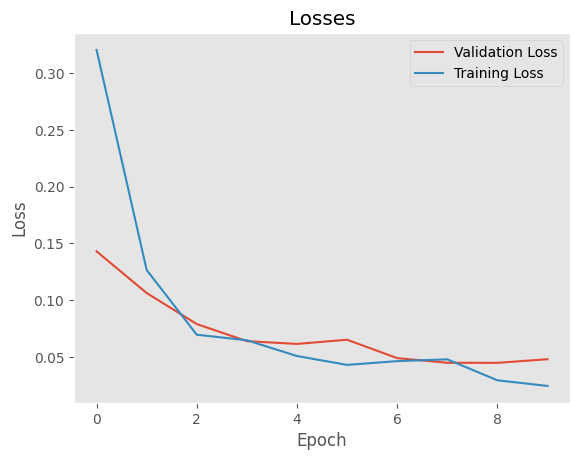

In [22]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [23]:
# Load best model trained
resnet50_tl.load_parameters(model.MODEL_FILE_NAME)

# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50_tl(images.as_in_context(ctx))
    
    softmax_output = mx.nd.softmax(output.as_nd_ndarray())
    class_output = np.argmax(softmax_output, axis=1)    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

('accuracy', 0.985)


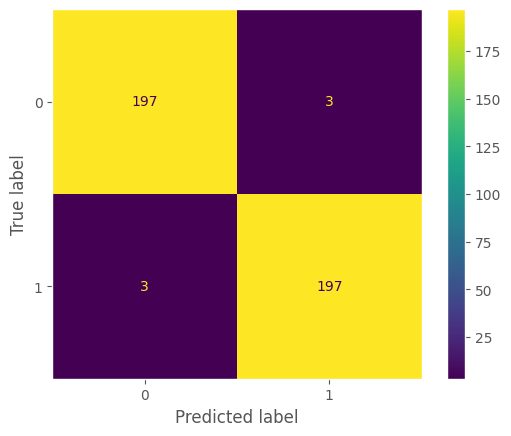

In [24]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp = cm_disp.plot(ax=None)
plt.grid(False)
plt.show()

In [25]:
# Qualitative Evaluation
# Expected Output 
print("Expected Output:", example_label) 
 
# Model Output
example_output = resnet50_tl(example_image_preprocessed)
class_output = np.argmax(example_output, axis=1).asnumpy()[0]
print("Class Output:", class_output) 
assert class_output == 0 # Cat 

Expected Output: 0
Class Output: 0


## Fine-Tuning (after Transfer Learning)

In [26]:
import model
reload(model)

# Build on top of Pre-Trained model
resnet50_ft = resnet50_tl

# Un-freeze weights
for param in resnet50_ft.collect_params().values(): 
    if param.name in updated_params:
        param.grad_req = 'write' 

# Define Loss Function (Binary, cats vs dogs)
# loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 10
batch_size = 16

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "sgd", {"learning_rate": 0.0001})

training_loss, training_acc, validation_loss, validation_acc = model.training_loop(resnet50_ft,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

E:    1, TrL: 1.015575, TrAcc: 0.671250, VL: 7.587902, VAcc: 0.560000 --- Updating saved model
E:    2, TrL: 0.802481, TrAcc: 0.591250, VL: 2.973028, VAcc: 0.550000
E:    3, TrL: 0.832130, TrAcc: 0.582500, VL: 0.700428, VAcc: 0.600000 --- Updating saved model
E:    4, TrL: 0.646767, TrAcc: 0.648750, VL: 0.598567, VAcc: 0.675000 --- Updating saved model
E:    5, TrL: 0.632787, TrAcc: 0.672500, VL: 2.046741, VAcc: 0.660000
E:    6, TrL: 0.583190, TrAcc: 0.706250, VL: 0.505488, VAcc: 0.770000 --- Updating saved model
E:    7, TrL: 0.524379, TrAcc: 0.758750, VL: 0.759254, VAcc: 0.715000
E:    8, TrL: 0.463217, TrAcc: 0.805000, VL: 4.211319, VAcc: 0.635000
E:    9, TrL: 0.456157, TrAcc: 0.777500, VL: 1.050544, VAcc: 0.675000
E:   10, TrL: 0.409904, TrAcc: 0.820000, VL: 0.751009, VAcc: 0.725000


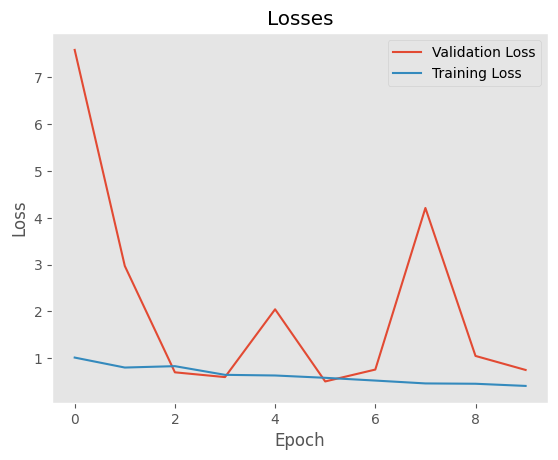

In [27]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [28]:
# Load best model trained
resnet50_ft.load_parameters(model.MODEL_FILE_NAME)

# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50_ft(images.as_in_context(ctx))
    
    softmax_output = mx.nd.softmax(output.as_nd_ndarray())
    class_output = np.argmax(softmax_output, axis=1)    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

('accuracy', 0.7775)


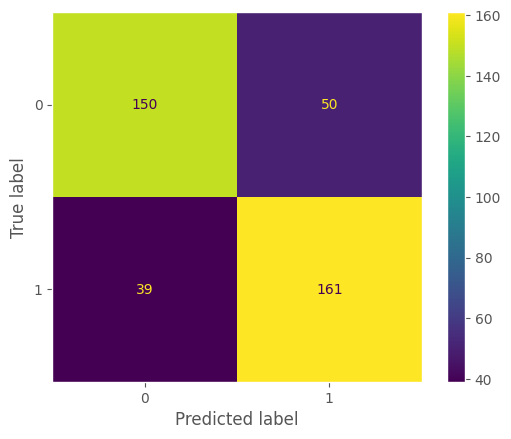

In [29]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp = cm_disp.plot(ax=None)
plt.grid(False)
plt.show()

In [30]:
# Qualitative Evaluation
# Expected Output 
print("Expected Output:", example_label) 
 
# Model Output
example_output = resnet50_ft(example_image_preprocessed)
class_output = np.argmax(example_output, axis=1).asnumpy()[0]
print("Class Output:", class_output) 
assert class_output == 0 # Cat 

Expected Output: 0
Class Output: 0


## Fine-Tuning (directly)

In [31]:
import model
reload(model)

# Build on top of Pre-Trained model
resnet50_ft_direct = gcv.model_zoo.get_model("resnet50_v1d", pretrained=True, ctx=ctx)

# Replace the classifier
resnet50_ft_direct.fc = mx.gluon.nn.Dense(2)
resnet50_ft_direct.fc.initialize(ctx=ctx)

# Define Loss Function (Binary, cats vs dogs)
# loss_fn = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss()
loss_fn = mx.gluon.loss.SoftmaxCrossEntropyLoss()

# Epochs & Batch Size
# Optimal values for full: "adam", lr: 0.01, 10+ epochs, batch size 256
# Optimal values for light: "adam", lr: 0.0001, 10+ epochs, batch size 16
epochs = 10
batch_size = 8

# Define Optimizer and Hyper Parameters
trainer = mx.gluon.Trainer(resnet50_ft_direct.collect_params(), "adam", {"learning_rate": 0.0001})
# trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "adam", {"learning_rate": 0.001})
# trainer = mx.gluon.Trainer(resnet50_ft.collect_params(), "sgd", {"learning_rate": 0.001})

training_loss, training_acc, validation_loss, validation_acc = model.training_loop(resnet50_ft_direct,
                                                                                   loss_fn,
                                                                                   trainer,
                                                                                   epochs,
                                                                                   batch_size,
                                                                                   train_dataset,
                                                                                   val_dataset,
                                                                                   ctx)

E:    1, TrL: 0.180961, TrAcc: 0.925000, VL: 0.243143, VAcc: 0.935000 --- Updating saved model
E:    2, TrL: 0.078365, TrAcc: 0.970000, VL: 0.054148, VAcc: 0.970000 --- Updating saved model
E:    3, TrL: 0.040224, TrAcc: 0.991250, VL: 0.063218, VAcc: 0.975000 --- Updating saved model
E:    4, TrL: 0.011902, TrAcc: 0.997500, VL: 0.057491, VAcc: 0.970000
E:    5, TrL: 0.004986, TrAcc: 1.000000, VL: 0.050828, VAcc: 0.975000
E:    6, TrL: 0.019283, TrAcc: 0.992500, VL: 0.186647, VAcc: 0.960000
E:    7, TrL: 0.032236, TrAcc: 0.990000, VL: 0.055314, VAcc: 0.985000 --- Updating saved model
E:    8, TrL: 0.008329, TrAcc: 0.997500, VL: 0.095382, VAcc: 0.970000
E:    9, TrL: 0.012820, TrAcc: 0.997500, VL: 0.064202, VAcc: 0.965000
E:   10, TrL: 0.016623, TrAcc: 0.995000, VL: 0.062601, VAcc: 0.975000


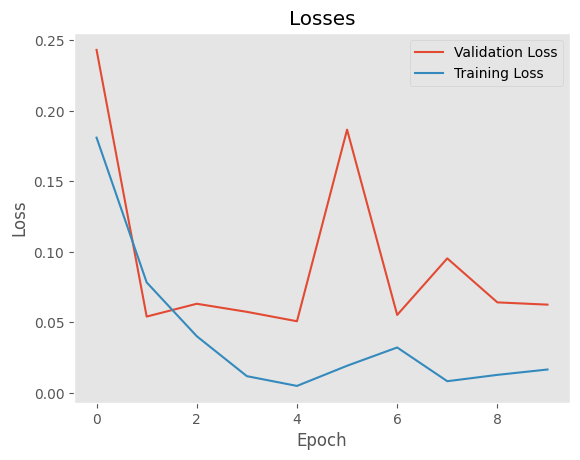

In [32]:
# plot the losses
epochs = 10

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), validation_loss[:epochs], label="Validation Loss")
plt.plot(np.arange(0, epochs), training_loss[:epochs], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Losses")
plt.grid(False)
plt.show()

In [33]:
# Load best model trained
resnet50_ft_direct.load_parameters(model.MODEL_FILE_NAME)

# Run testset through our network (ResNet50)
expected_outputs = []
class_outputs = []

acc = mx.metric.Accuracy()
f1  = mx.metric.F1()

for images, labels in test_dataldr:
    output = resnet50_ft_direct(images.as_in_context(ctx))
    
    softmax_output = mx.nd.softmax(output.as_nd_ndarray())
    class_output = np.argmax(softmax_output, axis=1)    
    acc.update(labels, class_output)
    
    expected_outputs += labels.tolist()
    class_outputs += class_output.asnumpy().tolist()

print(acc.get())

('accuracy', 0.98)


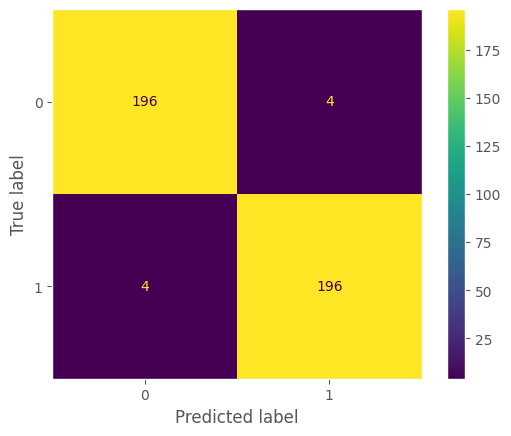

In [34]:
# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(expected_outputs, class_outputs)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
cm_disp = cm_disp.plot(ax=None)
plt.grid(False)
plt.show()

In [35]:
# Qualitative Evaluation
# Expected Output 
print("Expected Output:", example_label) 
 
# Model Output
example_output = resnet50_ft_direct(example_image_preprocessed)
class_output = np.argmax(example_output, axis=1).asnumpy()[0]
print("Class Output:", class_output) 
assert class_output == 0 # Cat 

Expected Output: 0
Class Output: 0
